In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

In [2]:
os.getcwd()

'/content'

In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
!ls

drive  sample_data


In [6]:
!ls /content/drive/MyDrive/archive.zip

/content/drive/MyDrive/archive.zip


In [ ]:
!unzip /content/drive/MyDrive/archive.zip -d /content/

In [ ]:
!ls /content/data

In [9]:
batch_size = 128

train_dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/data', label_mode = None,
                                                                    image_size = (64,64), batch_size = batch_size)     


# scaling the images to (-1, 1)
train_dataset = train_dataset.map(lambda x: (x /127.5) - 1)                                                                                       

Found 43102 files belonging to 1 classes.


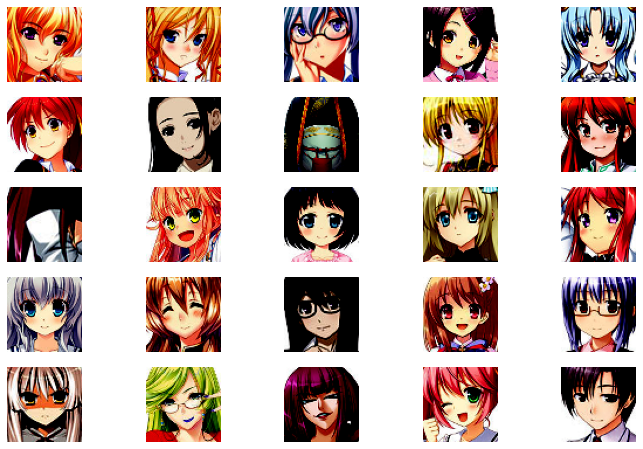

In [10]:
plt.figure(figsize=(12, 8))

for images in train_dataset.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis("off")


Image_hape(64, 64, 3)


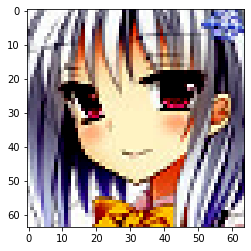

In [11]:
for batch in train_dataset:
  plt.imshow(batch[0])
  print(f"Image_hape{batch[0].shape}")
  break

In [12]:
# Init the weights with normal normal gaussian distribution since the model is relatively complex so as to converge faster
init_weights_kernel = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [18]:
# The Generator model
def generator_model():
  model = tf.keras.Sequential()

  # take the 100D noise and reshape it properly
  model.add(layers.Input(shape = (100, )))
  model.add(layers.Dense(4 * 4 * 256)) # so as to project the input and reshpe it to 4D tensor
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((4, 4, 256)))


  # the TransCNN block
  model.add(layers.Conv2DTranspose(128, kernel_size = 4, padding = "same", strides = 2,
                                   kernel_initializer = init_weights_kernel, use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(64, kernel_size = 4, padding = "same", strides = 2,
                                   kernel_initializer = init_weights_kernel, use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(32, kernel_size = 4, padding = "same", strides = 2,
                                   kernel_initializer = init_weights_kernel, use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(3, kernel_size = 4, padding = "same", strides = 2, activation = "tanh",
                                   kernel_initializer = init_weights_kernel, use_bias = False))
  
  return model


In [19]:
generator = generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 batch_normalization_4 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 128)        524288    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 128)       

In [20]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training = False)

generated_image.shape

TensorShape([1, 64, 64, 3])

In [21]:
generated_image[0, :5, :5]

<tf.Tensor: shape=(5, 5, 3), dtype=float32, numpy=
array([[[ 6.99935481e-05, -3.52790885e-05, -2.18886016e-05],
        [ 2.12119630e-04, -1.68795741e-05,  2.88137599e-05],
        [ 2.72429606e-04,  1.56438575e-04, -9.93797148e-05],
        [-2.94612655e-05,  5.74847858e-04, -2.11663792e-06],
        [ 1.55423346e-04, -1.93376211e-04,  3.47965077e-04]],

       [[ 1.12858994e-04,  1.98337046e-04, -2.11691746e-04],
        [-6.82113314e-05, -3.40513070e-04,  6.13243974e-05],
        [ 2.54931394e-04,  4.97081841e-04,  3.74989293e-04],
        [ 9.54759365e-04,  1.48382387e-05,  8.10662925e-04],
        [-3.69784102e-04,  6.01756503e-04, -4.44934674e-04]],

       [[-2.66125717e-05,  8.78869832e-05, -2.58168584e-04],
        [ 1.93996544e-04,  5.96927945e-04, -5.94991798e-05],
        [ 7.97617133e-04, -3.26526642e-04,  4.36715287e-04],
        [-1.69385778e-04,  4.51612083e-04,  3.47357491e-05],
        [ 5.56002720e-04, -7.72979227e-04,  1.11707624e-04]],

       [[ 2.23759125e-04,  3

##################################################
Since the model is not trained thre output is just a pure noise


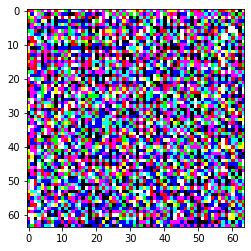

In [24]:
plt.imshow(generated_image[0, :, :, :] * 255 * 100)
print("#" * 50)
print("Since the model is not trained thre output is just a pure noise")

In [26]:
# The Discriminator model
def discriminator_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(32, kernel_size = 3, strides = 2, input_shape = (64, 64, 3), padding = "same",
                          kernel_initializer = init_weights_kernel, use_bias = False))
  model.add(layers.LeakyReLU(alpha = 0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(64, kernel_size = 3, strides = 2, padding = "same",
                          kernel_initializer = init_weights_kernel, use_bias = False))
  model.add(layers.ZeroPadding2D(padding = ((0, 1), (0, 1))))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha = 0.2))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(128, kernel_size = 3, strides = 2, padding = "same",
                          kernel_initializer = init_weights_kernel, use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha = 0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256, kernel_size = 3, strides = 2, padding = "same",
                          kernel_initializer = init_weights_kernel, use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha = 0.2))
  model.add(layers.Dropout(0.3))


  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation = "sigmoid"))

  return model

In [27]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        864       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18432     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 17, 17, 64)       256       
 hNormalization)                                      

In [28]:
# check the model without training
output = discriminator(generated_image)
print(output)

tf.Tensor([[0.5000011]], shape=(1, 1), dtype=float32)


In [39]:
# init the loss

bce = tf.keras.losses.BinaryCrossentropy()

In [40]:
def discriminator_loss(real_output, fake_output):
  real_loss = bce(tf.ones_like(real_output), real_output)
  fake_loss = bce(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss
  return total_loss

In [41]:
def generator_loss(fake_output):
  gen_loss = bce(tf.ones_like(fake_output), fake_output)

  return gen_loss

In [42]:
# init optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

In [43]:
checkpoint_dir = "./traning_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "cpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [44]:
# training params

epochs = 40
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [45]:
def generate_and_plot_images(model, epoch, test_input):

  predictions = model(test_input, training = False)

  fig = plt.figure(figsize = (8, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
    plt.axis("off")

  plt.savefig("Image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

In [46]:
# How to train a single batch of images(aka: what is being done at each step of training)

def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  
  gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradient_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

  return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))


In [49]:
# Running the training for specified number of epochs,
# and for each batch of trianing it will invoke the train_step function

def train(dataset, epochs):
  gen_loss_list = []
  disc_loss_list = []

  real_score_list = []
  fake_score_list = []

  for epoch in tqdm(range(epochs)):
    start = time.time()
    num_batches = len(dataset)

    print(f"Training started with epoch {epoch + 1} with {num_batches} batches...")

    total_gen_loss = 0
    total_disc_loss = 0

    for batch in dataset:
      generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)

      total_gen_loss += generator_loss
      total_disc_loss += discriminator_loss

    mean_gen_loss = total_gen_loss / num_batches
    mean_disc_loss = total_disc_loss / num_batches

    print('Losses after epoch %5d: generator %.3f, discriminator %.3f,\
           real_score %.2f%%, fake_score %.2f%%' %
           (epoch+1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

    generate_and_plot_images(generator, epoch + 1, seed)

    gen_loss_list.append(mean_gen_loss)
    disc_loss_list.append(mean_disc_loss)
    real_score_list.append(real_score)
    fake_score_list.append(fake_score)

    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print(f"Time for the {epoch + 1} is {time.time() - start}")
  

  return gen_loss_list, disc_loss_list, real_score_list, fake_score_list


  0%|          | 0/40 [00:00<?, ?it/s]

Training started with epoch 1 with 337 batches...
Losses after epoch     1: generator 5.047, discriminator 0.375,           real_score 82.60%, fake_score 3.85%


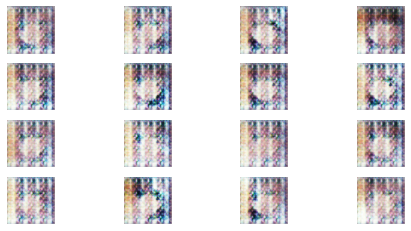

  2%|▎         | 1/40 [01:22<53:34, 82.43s/it]

Time for the 1 is 82.4309720993042
Training started with epoch 2 with 337 batches...
Losses after epoch     2: generator 2.710, discriminator 0.374,           real_score 90.25%, fake_score 16.95%


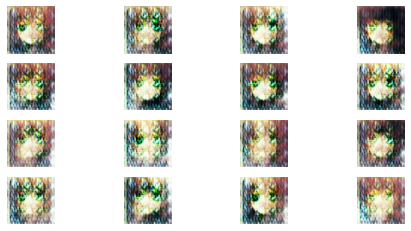

  5%|▌         | 2/40 [02:06<38:01, 60.05s/it]

Time for the 2 is 44.3726851940155
Training started with epoch 3 with 337 batches...
Losses after epoch     3: generator 3.180, discriminator 0.302,           real_score 91.75%, fake_score 13.63%


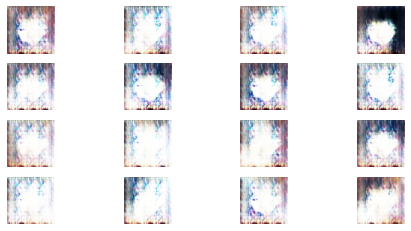

  8%|▊         | 3/40 [02:50<32:32, 52.78s/it]

Time for the 3 is 44.113099336624146
Training started with epoch 4 with 337 batches...
Losses after epoch     4: generator 4.591, discriminator 0.617,           real_score 72.95%, fake_score 4.53%


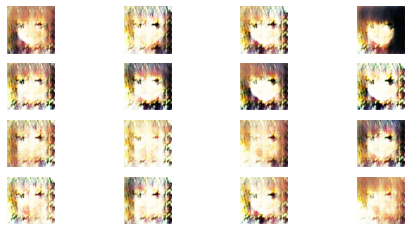

 10%|█         | 4/40 [04:13<38:41, 64.50s/it]

Time for the 4 is 82.46165132522583
Training started with epoch 5 with 337 batches...
Losses after epoch     5: generator 2.061, discriminator 0.417,           real_score 95.14%, fake_score 24.52%


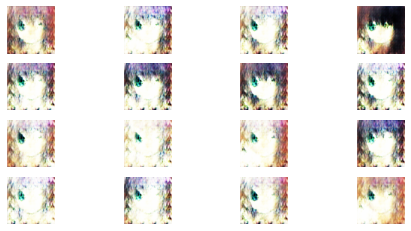

 12%|█▎        | 5/40 [04:58<33:37, 57.63s/it]

Time for the 5 is 45.454811573028564
Training started with epoch 6 with 337 batches...
Losses after epoch     6: generator 3.366, discriminator 0.256,           real_score 90.54%, fake_score 9.12%


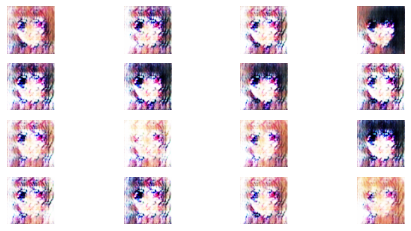

 15%|█▌        | 6/40 [06:21<37:26, 66.08s/it]

Time for the 6 is 82.48637366294861
Training started with epoch 7 with 337 batches...
Losses after epoch     7: generator 3.376, discriminator 0.182,           real_score 94.73%, fake_score 9.54%


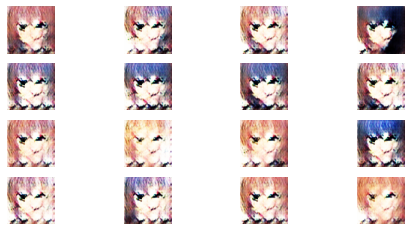

 18%|█▊        | 7/40 [07:05<32:26, 59.00s/it]

Time for the 7 is 44.400049686431885
Training started with epoch 8 with 337 batches...
Losses after epoch     8: generator 4.128, discriminator 0.254,           real_score 85.72%, fake_score 4.53%


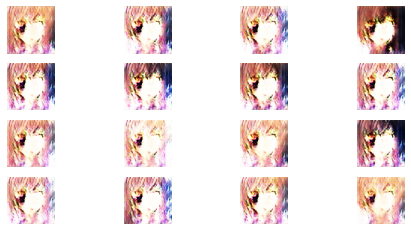

 20%|██        | 8/40 [07:50<28:59, 54.36s/it]

Time for the 8 is 44.4109411239624
Training started with epoch 9 with 337 batches...
Losses after epoch     9: generator 2.877, discriminator 0.354,           real_score 92.34%, fake_score 15.95%


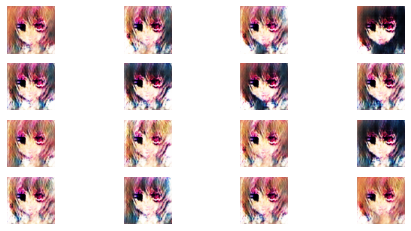

 22%|██▎       | 9/40 [08:34<26:28, 51.24s/it]

Time for the 9 is 44.39106559753418
Training started with epoch 10 with 337 batches...
Losses after epoch    10: generator 2.541, discriminator 0.344,           real_score 95.75%, fake_score 19.11%


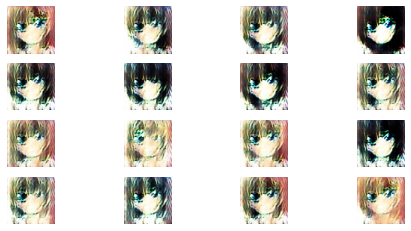

 25%|██▌       | 10/40 [09:18<24:30, 49.03s/it]

Time for the 10 is 44.07944869995117
Training started with epoch 11 with 337 batches...
Losses after epoch    11: generator 5.649, discriminator 0.453,           real_score 76.52%, fake_score 1.60%


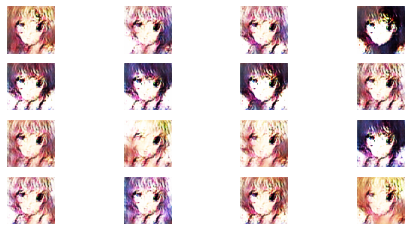

 28%|██▊       | 11/40 [10:06<23:29, 48.59s/it]

Time for the 11 is 47.58258557319641
Training started with epoch 12 with 337 batches...
Losses after epoch    12: generator 3.198, discriminator 0.210,           real_score 93.81%, fake_score 10.54%


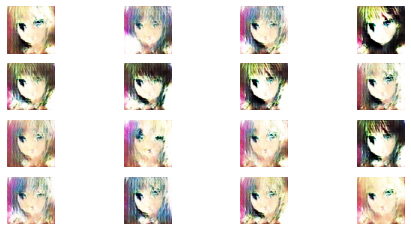

 30%|███       | 12/40 [11:28<27:30, 58.96s/it]

Time for the 12 is 82.68553185462952
Training started with epoch 13 with 337 batches...
Losses after epoch    13: generator 1.740, discriminator 0.675,           real_score 90.01%, fake_score 31.50%


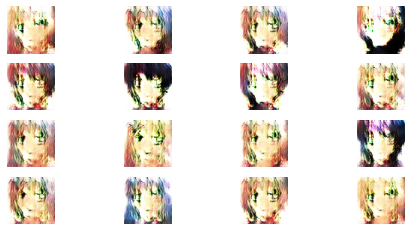

 32%|███▎      | 13/40 [12:13<24:36, 54.69s/it]

Time for the 13 is 44.84641480445862
Training started with epoch 14 with 337 batches...
Losses after epoch    14: generator 3.019, discriminator 0.383,           real_score 88.20%, fake_score 13.73%


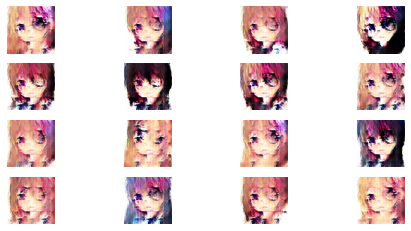

 35%|███▌      | 14/40 [13:36<27:19, 63.07s/it]

Time for the 14 is 82.45179152488708
Training started with epoch 15 with 337 batches...
Losses after epoch    15: generator 3.790, discriminator 0.150,           real_score 96.17%, fake_score 7.87%


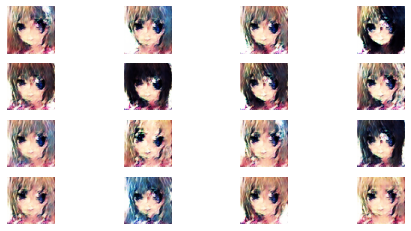

 38%|███▊      | 15/40 [14:24<24:21, 58.48s/it]

Time for the 15 is 47.81685543060303
Training started with epoch 16 with 337 batches...
Losses after epoch    16: generator 3.234, discriminator 0.442,           real_score 86.27%, fake_score 12.95%


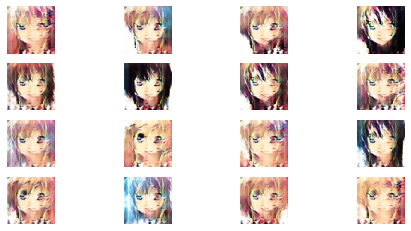

 40%|████      | 16/40 [15:08<21:44, 54.34s/it]

Time for the 16 is 44.7235894203186
Training started with epoch 17 with 337 batches...
Losses after epoch    17: generator 2.335, discriminator 0.469,           real_score 94.86%, fake_score 24.09%


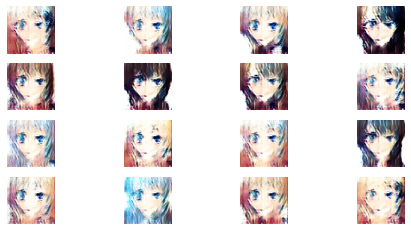

 42%|████▎     | 17/40 [16:31<24:04, 62.80s/it]

Time for the 17 is 82.45864486694336
Training started with epoch 18 with 337 batches...
Losses after epoch    18: generator 2.660, discriminator 0.476,           real_score 94.93%, fake_score 22.26%


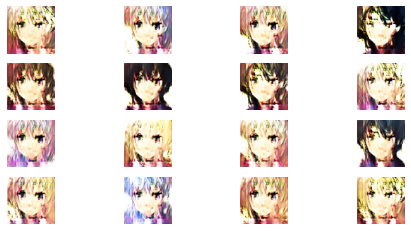

 45%|████▌     | 18/40 [17:53<25:11, 68.70s/it]

Time for the 18 is 82.44488763809204
Training started with epoch 19 with 337 batches...
Losses after epoch    19: generator 3.160, discriminator 0.327,           real_score 91.32%, fake_score 14.54%


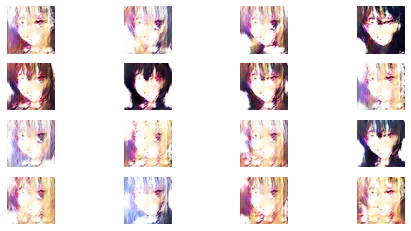

 48%|████▊     | 19/40 [18:41<21:51, 62.43s/it]

Time for the 19 is 47.81741213798523
Training started with epoch 20 with 337 batches...
Losses after epoch    20: generator 3.666, discriminator 0.356,           real_score 87.80%, fake_score 9.68%


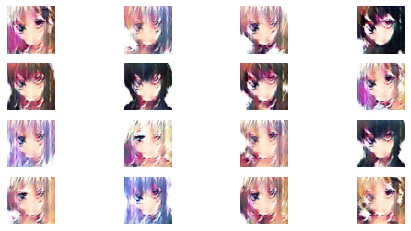

 50%|█████     | 20/40 [19:26<19:04, 57.23s/it]

Time for the 20 is 45.085256576538086
Training started with epoch 21 with 337 batches...
Losses after epoch    21: generator 1.817, discriminator 0.636,           real_score 94.57%, fake_score 31.90%


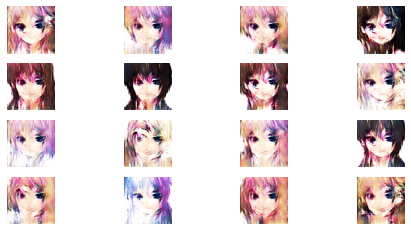

 52%|█████▎    | 21/40 [20:11<16:55, 53.43s/it]

Time for the 21 is 44.56497550010681
Training started with epoch 22 with 337 batches...
Losses after epoch    22: generator 1.966, discriminator 0.545,           real_score 97.59%, fake_score 29.70%


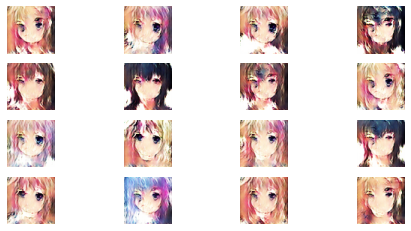

 55%|█████▌    | 22/40 [21:33<18:38, 62.13s/it]

Time for the 22 is 82.42638301849365
Training started with epoch 23 with 337 batches...
Losses after epoch    23: generator 2.839, discriminator 0.350,           real_score 87.42%, fake_score 13.97%


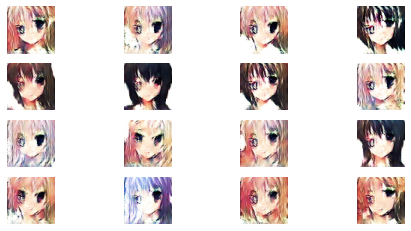

 57%|█████▊    | 23/40 [22:56<19:19, 68.23s/it]

Time for the 23 is 82.43655753135681
Training started with epoch 24 with 337 batches...
Losses after epoch    24: generator 3.535, discriminator 0.359,           real_score 86.57%, fake_score 9.74%


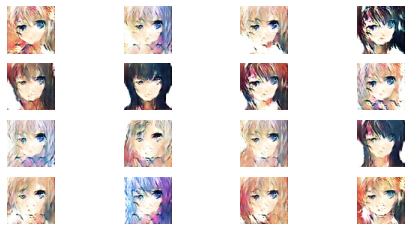

 60%|██████    | 24/40 [24:18<19:21, 72.57s/it]

Time for the 24 is 82.70591378211975
Training started with epoch 25 with 337 batches...
Losses after epoch    25: generator 5.614, discriminator 0.645,           real_score 68.83%, fake_score 2.47%


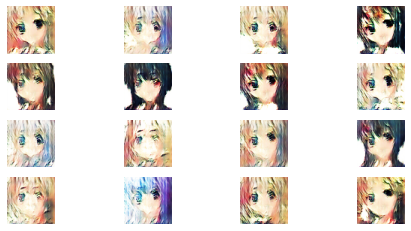

 62%|██████▎   | 25/40 [25:41<18:53, 75.54s/it]

Time for the 25 is 82.44659495353699
Training started with epoch 26 with 337 batches...
Losses after epoch    26: generator 3.976, discriminator 0.444,           real_score 82.83%, fake_score 9.53%


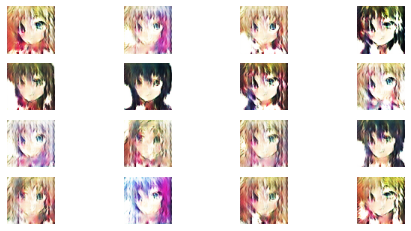

 65%|██████▌   | 26/40 [27:03<18:06, 77.62s/it]

Time for the 26 is 82.47564959526062
Training started with epoch 27 with 337 batches...
Losses after epoch    27: generator 2.330, discriminator 0.429,           real_score 93.68%, fake_score 21.23%


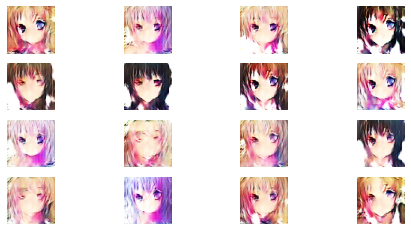

 68%|██████▊   | 27/40 [27:51<14:53, 68.70s/it]

Time for the 27 is 47.87427639961243
Training started with epoch 28 with 337 batches...
Losses after epoch    28: generator 4.075, discriminator 0.253,           real_score 88.97%, fake_score 7.45%


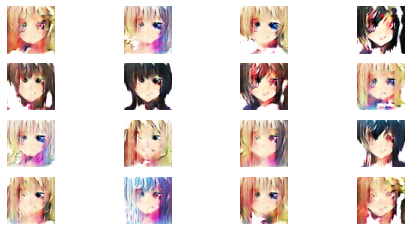

 70%|███████   | 28/40 [29:14<14:34, 72.90s/it]

Time for the 28 is 82.68947672843933
Training started with epoch 29 with 337 batches...
Losses after epoch    29: generator 2.258, discriminator 0.427,           real_score 92.69%, fake_score 21.74%


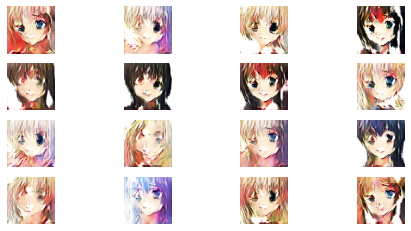

 72%|███████▎  | 29/40 [29:58<11:47, 64.34s/it]

Time for the 29 is 44.359874963760376
Training started with epoch 30 with 337 batches...
Losses after epoch    30: generator 2.748, discriminator 0.389,           real_score 92.13%, fake_score 18.17%


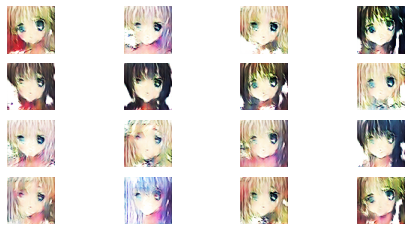

 75%|███████▌  | 30/40 [31:21<11:38, 69.80s/it]

Time for the 30 is 82.55836653709412
Training started with epoch 31 with 337 batches...
Losses after epoch    31: generator 3.386, discriminator 0.337,           real_score 87.43%, fake_score 11.11%


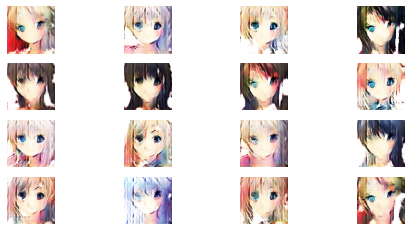

 78%|███████▊  | 31/40 [32:09<09:28, 63.22s/it]

Time for the 31 is 47.83697247505188
Training started with epoch 32 with 337 batches...
Losses after epoch    32: generator 3.730, discriminator 0.242,           real_score 89.04%, fake_score 8.48%


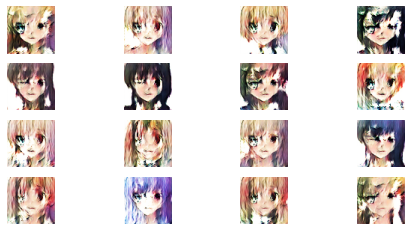

 80%|████████  | 32/40 [33:31<09:11, 68.99s/it]

Time for the 32 is 82.47182106971741
Training started with epoch 33 with 337 batches...
Losses after epoch    33: generator 3.386, discriminator 0.320,           real_score 89.85%, fake_score 12.15%


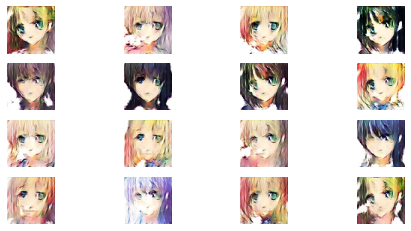

 82%|████████▎ | 33/40 [34:18<07:16, 62.41s/it]

Time for the 33 is 47.03544068336487
Training started with epoch 34 with 337 batches...
Losses after epoch    34: generator 3.148, discriminator 0.267,           real_score 97.28%, fake_score 14.53%


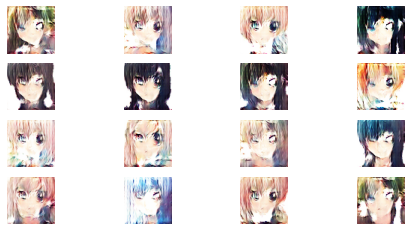

 85%|████████▌ | 34/40 [35:04<05:45, 57.52s/it]

Time for the 34 is 46.12315011024475
Training started with epoch 35 with 337 batches...
Losses after epoch    35: generator 2.196, discriminator 0.544,           real_score 89.93%, fake_score 25.18%


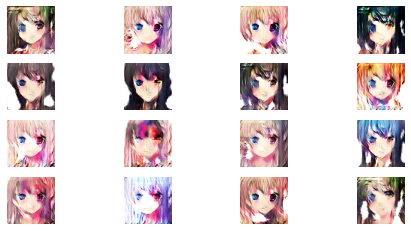

 88%|████████▊ | 35/40 [35:50<04:30, 54.08s/it]

Time for the 35 is 46.02862572669983
Training started with epoch 36 with 337 batches...
Losses after epoch    36: generator 3.822, discriminator 0.467,           real_score 79.07%, fake_score 9.36%


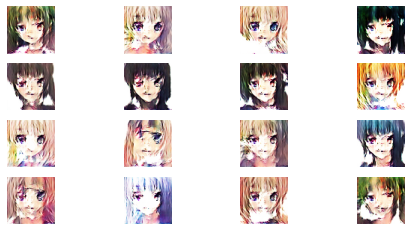

 90%|█████████ | 36/40 [36:40<03:31, 52.84s/it]

Time for the 36 is 49.9468560218811
Training started with epoch 37 with 337 batches...
Losses after epoch    37: generator 2.576, discriminator 0.380,           real_score 94.40%, fake_score 19.95%


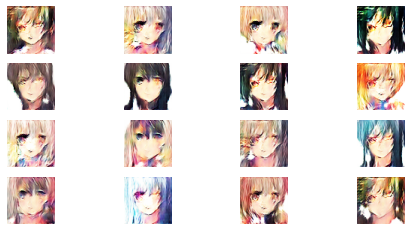

 92%|█████████▎| 37/40 [37:27<02:33, 51.07s/it]

Time for the 37 is 46.951380252838135
Training started with epoch 38 with 337 batches...
Losses after epoch    38: generator 4.557, discriminator 0.302,           real_score 85.69%, fake_score 5.51%


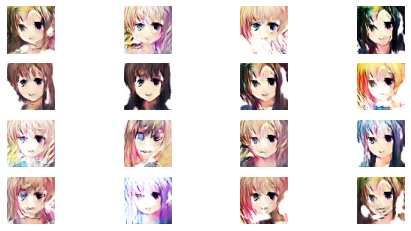

 95%|█████████▌| 38/40 [38:11<01:38, 49.03s/it]

Time for the 38 is 44.2428195476532
Training started with epoch 39 with 337 batches...
Losses after epoch    39: generator 4.160, discriminator 0.233,           real_score 88.55%, fake_score 6.76%


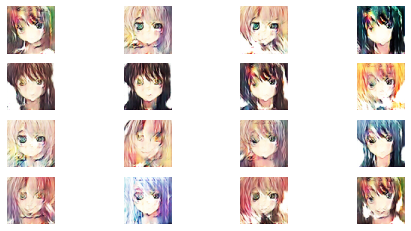

 98%|█████████▊| 39/40 [38:54<00:47, 47.14s/it]

Time for the 39 is 42.74299764633179
Training started with epoch 40 with 337 batches...
Losses after epoch    40: generator 3.336, discriminator 0.460,           real_score 84.66%, fake_score 13.51%


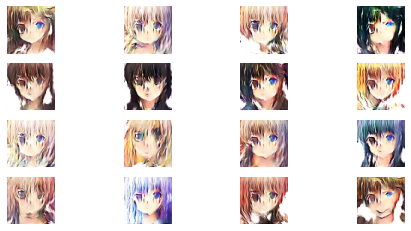

100%|██████████| 40/40 [39:36<00:00, 59.42s/it]

Time for the 40 is 42.0887656211853


In [50]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs= epochs)

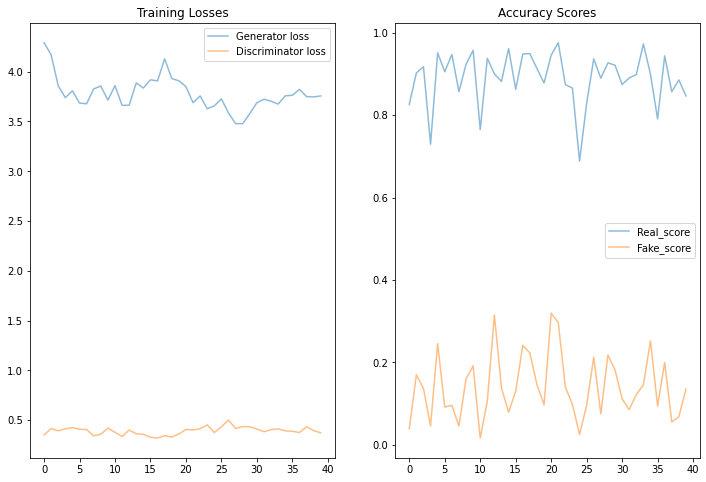

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))

ax1.plot(gen_loss_epochs, label = "Generator loss", alpha = 0.5)
ax1.plot(disc_loss_epochs, label = "Discriminator loss", alpha = 0.5)
ax1.legend()
ax1.set_title("Training Losses")

ax2.plot(real_score_list, label = "Real_score", alpha = 0.5)
ax2.plot(fake_score_list, label = "Fake_score", alpha = 0.5)
ax2.set_title("Accuracy Scores")

ax2.legend()

In [59]:
def generate_anime_face():
  noise_test = tf.random.normal([1, 100])

  generated_image_test = generator(noise_test, training = False)

  generated_image_test.shape

  plt.imshow(generated_image_test[0, :, :, :] * 255 * 100)

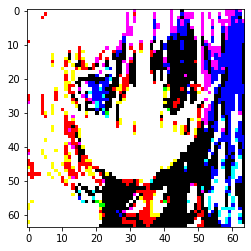

In [71]:
generate_anime_face()